In [1793]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import timedelta
from datetime import datetime
import matplotlib.dates as mdates

import seaborn
seaborn.set(font_scale=1.5,style='ticks')
clrs = seaborn.color_palette()


In [1821]:
ROOT_dir = 'C:/Users/takam/Desktop/pyhomecage/mice/'

In [1822]:
mouse_fs = [os.path.join(ROOT_dir,i) for i in os.listdir(ROOT_dir) if 'mice' not in i]

In [1867]:
mix = 2
df = pd.read_csv(mouse_fs[mix])

In [1868]:
now = datetime.now()

In [1869]:
df['entry_time']= pd.to_datetime(df['entry_time'])


In [1870]:
n_days_back = 1

weights = df[df['entry_time']>(now-timedelta(days=n_days_back))]['weight'].values
time = df[df['entry_time']>(now-timedelta(days=n_days_back))]['entry_time'].values

In [1871]:
variables = df[df['entry_time']>(now-timedelta(days=n_days_back))]['Variables'].values
sum([int(eval(i)['n_rewards']) for i in variables if int(eval(i)['n_rewards'])<200])

8

In [1872]:
[int(eval(i)['n_rewards']) for i in variables if int(eval(i)['n_rewards'])<200]

[4, 2, 2]

In [1873]:
(now-timedelta(days=n_days_back))

datetime.datetime(2021, 4, 11, 12, 9, 34, 228278)

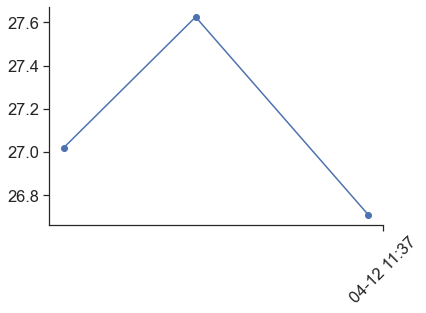

In [1874]:
plt.plot(time,weights,marker='o')
plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,4))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes


seaborn.despine()

In [1875]:
import pykalman

In [1876]:
t_ = (time[-1] -time[0])
t_ = t_.astype('timedelta64[h]')
n_hours = 1+ t_.item().total_seconds()/3600.

In [1877]:
start_time

datetime.datetime(2021, 4, 8, 18, 19, 31)

In [1878]:
tm

datetime.datetime(2021, 4, 12, 11, 30, 41)

In [1879]:
timestep = 30 #timestep size in minutes
#start_time = time[0]
start_time = datetime.utcfromtimestamp(time[0].tolist()/1e9)
n_timesteps = int((1+n_hours)*(60/timestep))
weights_kf = np.zeros(n_timesteps) + np.nan
kf_times = [start_time]
for t_ in range(1,n_timesteps):
    tdt = start_time + timedelta(minutes=timestep*t_)
    weights_at_t = []
    for w,tm in zip(weights,time):
        tm = datetime.utcfromtimestamp(tm.tolist()/1e9)
        if abs((tm-tdt).total_seconds())<(timestep*60):
            #print(tm,tdt,(tm-tdt).total_seconds())
            weights_at_t.append(w)
            
            
    if weights_at_t:
        weights_kf[t_] = np.mean(weights_at_t)
    kf_times.append(tdt)
        

In [1880]:
weights_kf_ma = np.ma.masked_invalid(weights_kf)

In [1881]:
kf = pykalman.KalmanFilter(initial_state_mean=weights[0],observation_covariance=[2])

In [1882]:
em_vars = ['transition_covariance',
           'initial_state_mean', 
           'observation_covariance',
           'initial_state_covariance']
kf.em(weights_kf_ma,n_iter=5,em_vars=em_vars)
a,b = kf.smooth(weights_kf_ma,)
mu = a.flatten()
std = np.sqrt(b.flatten())

In [1883]:
kf.transition_covariance

array([[0.49599614]])

In [1884]:
kf.observation_covariance

array([[0.22917384]])

In [1885]:
weights_kf_ma.mask.sum()

3

In [1886]:
kf.transition_matrices

array([[1.]])

In [1887]:
len(kf_times)

4

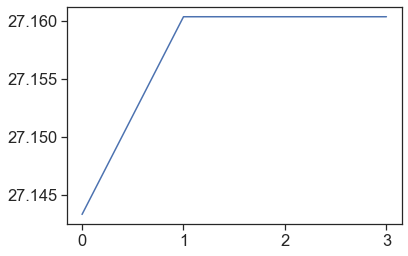

In [1888]:
plt.plot(mu)

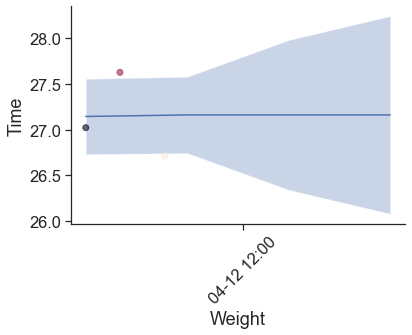

In [1889]:
x_ = time
plt.plot(kf_times,a)
plt.fill_between(kf_times,mu-std,mu+std,alpha=.3)
plt.scatter(x_,weights,alpha=.6,c=clrs[0])

plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,6))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes
plt.xlabel("Weight")
plt.ylabel("Time")
seaborn.despine()

In [1890]:
print(mu[-1],weights[-1])

27.160327701040583 26.71098


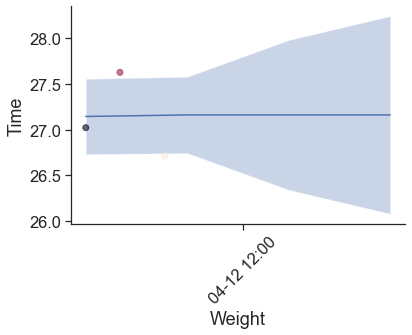

In [1891]:
x_ = time
plt.plot(kf_times,a)
plt.fill_between(kf_times,mu-std,mu+std,alpha=.3)
plt.scatter(x_,weights,alpha=.6,c=clrs[0])

plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,4))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes
plt.xlabel("Weight")
plt.ylabel("Time")
seaborn.despine()

In [1892]:
b.flat